In [1]:
import numpy as np
import networkx as nx

# Un-biased random walk for DeepWalk
## Return values and parameters of the Random walk class
- `adj_mat` : Get the adjacency matrix of the network.
- `walk_len` : Get the length of random walk to generate.
- `start_node` : Get the starting point for the random walk.
- `get_final_walk()` : Return the walk as a list of integers.

## Algorithm
- Start a dfs from the `start_node` node.
- With uniform probability pick a neighbour to go in the next step of the `dfs`.
- Continue for `walk_len` steps.

In [47]:
def unbiased_random_walk(adj_mat : 'list[list[int]]', walk_len : 'int', start_node : 'int'):
        """
        Returns a random walk of length walk_len from start_node in the graph.

        Parameters
        ----------
        adj_mat : list[list[int]]
            Adjacency matrix of the graph.
        walk_len : int
                Length of the random walk.
        start_node : int
                Starting node of the random walk.

        Returns
        -------
        list[int]
                List of nodes in the random walk.        
        """
        # Array to store the walk
        walk = [start_node]

        # Make an adjacency matrix to easily 
        # sample the neighbors of a node.
        adj_list = []
        for i in range(len(adj_mat) - 1):
                # This line was autocompleted by GH Copilot
                adj_list.append(np.where(adj_mat[i] > 0)[0])

        # Keep walking for walk_len epochs
        for epochs in range(walk_len):
                # Randomly pick a node from the adj_list[walk[-1]] 
                # and append it to the walk
                walk.append(np.random.choice(adj_list[walk[-1] - 1]))

        return np.array(walk)

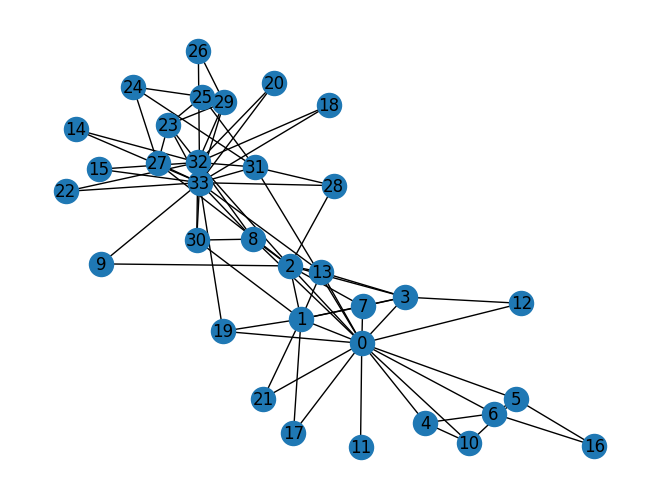

In [48]:
# Get the karate graph
G = nx.karate_club_graph()

# Print the G
nx.draw(G, with_labels=True)

In [49]:
# Print a random walk
print(unbiased_random_walk(nx.adjacency_matrix(G).todense(), 10, 3))

[ 3  0 30 33 23 32 28  2  0 20  1]
